In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from twitter.twitter_collection import TwitterCollection
from twitter.tweet_sentiment_analyzer import TweetSentimentAnalyzer
from data_pipelines.data_manipulation import DataManipulation
from logger.logger import Logger

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

Python-dotenv could not parse statement starting at line 11
[nltk_data] Downloading package stopwords to /home/kozan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using state Antalya server backend.


In [2]:
SYMBOL = 'BTC-USD'
SYMBOL_NAME = 'Bitcoin'
SYMBOL_CUT = 'btc'
scale = 1
range_list = [i for i in range(5,21)]
range_list = [i*scale for i in range_list]
interval = '1d'
start_date = '2020-06-30'
end_date = '2022-06-30'
source = 'yahoo'
LOG_PATH = '../logger' + os.sep + "logs"
LOG_FILE_NAME_PREFIX = f"log_{SYMBOL_CUT}_{start_date}_{end_date}"

logger = Logger(LOG_PATH, LOG_FILE_NAME_PREFIX)
tsa = TweetSentimentAnalyzer()
data = DataManipulation(SYMBOL, source, range_list, start_date=start_date, 
                        end_date=end_date, interval=interval, scale=scale, 
                        prefix_path='..', saved_to_csv=True,
                        logger=logger)
df_price = data.df.copy()

1 ) 16-12-2022 17_41_41 MainThread INFO\ Initialized logging at path ../logger/logs/log_btc_2020-06-30_2022-06-30_16-12-2022_17_41_41.log
2 ) 16-12-2022 17_41_41 MainThread DEBUG\ Get data from local file ../data/outputs/data_ind/BTC-USD/BTC-USD_df_2020-06-30_2022-06-30_1d.csv


In [3]:
df_price_ext = data.extract_features()
close_col = df_price.loc['2021-01-01':'2022-06-27',['close','volume']].copy()

In [4]:
sent_tweets = pd.read_csv('btc_archieve/btc_daily_sent_score.csv')
sent_tweets.Date = pd.to_datetime(sent_tweets.Date)
sent_tweets.set_index('Date', inplace=True, drop=True)

In [5]:
#sent_tweets.index = sent_tweets.index.tz_convert(None)

In [6]:
df_final = tsa.concat_ohlc_compound_score(df_price_ext, sent_tweets)
df_final = df_final.loc['2021-01-01':,:].copy()
df_final.dropna(inplace=True)

In [7]:
sent_tweets.head()

,compound_total
Date,
2021-01-01,0.1744
2021-01-02,0.1280
2021-01-03,0.1604
2021-01-04,0.1499
2021-01-05,0.1652


In [8]:
#data.normalized_df(df_final, 'compound_total')
#data.normalized_df(df_final, 'kz_score')
df_final.tail()

,ad,adj_close,adx_10,adx_15,adx_20,adx_5,adx_6,adx_7,adx_8,atrr_10,...,willr_8,wma_10,wma_15,wma_20,wma_5,wma_6,wma_7,wma_8,feature_label,compound_total
2022-06-24,2900352419804.9028,21231.6562,50.6548,41.6869,37.3558,55.3181,58.0620,57.4752,55.4630,1586.8532,...,-9.9430,20620.8111,21118.9952,22235.1258,20832.2406,20792.9323,20708.4711,20652.6190,1.0000,0.0952
2022-06-25,2917498015564.4307,21502.3379,50.1073,41.9850,37.7302,48.9315,53.8681,54.7735,53.7748,1483.8007,...,-3.0238,20773.7528,21010.8455,21957.8618,21092.0401,21023.6970,20970.2837,20884.8859,0.0000,0.0899
2022-06-26,2899988807883.1265,21027.2949,49.0016,42.0105,37.9491,40.9117,48.4339,51.0897,51.2866,1412.1661,...,-20.3529,20859.7868,20906.4944,21675.3762,21133.3052,21073.5415,21024.5965,20982.9529,0.0000,0.1090
2022-06-27,2884657654830.3213,20735.4785,48.4089,42.1887,38.2412,37.8106,45.6992,49.0314,49.8482,1356.7386,...,-50.0463,20881.0242,20826.7788,21414.3528,21056.1850,21019.6404,20989.0257,20960.3480,0.0000,0.1052
2022-06-28,2865644709192.0762,20280.6348,48.2603,42.5056,38.6012,38.0654,45.0005,48.2714,49.2796,1314.6258,...,-77.6531,20814.7629,20740.4341,21159.6299,20777.5536,20834.5992,20834.8890,20831.6055,0.0000,0.0993


AttributeError: 'DataFrame' object has no attribute 'compound_total'

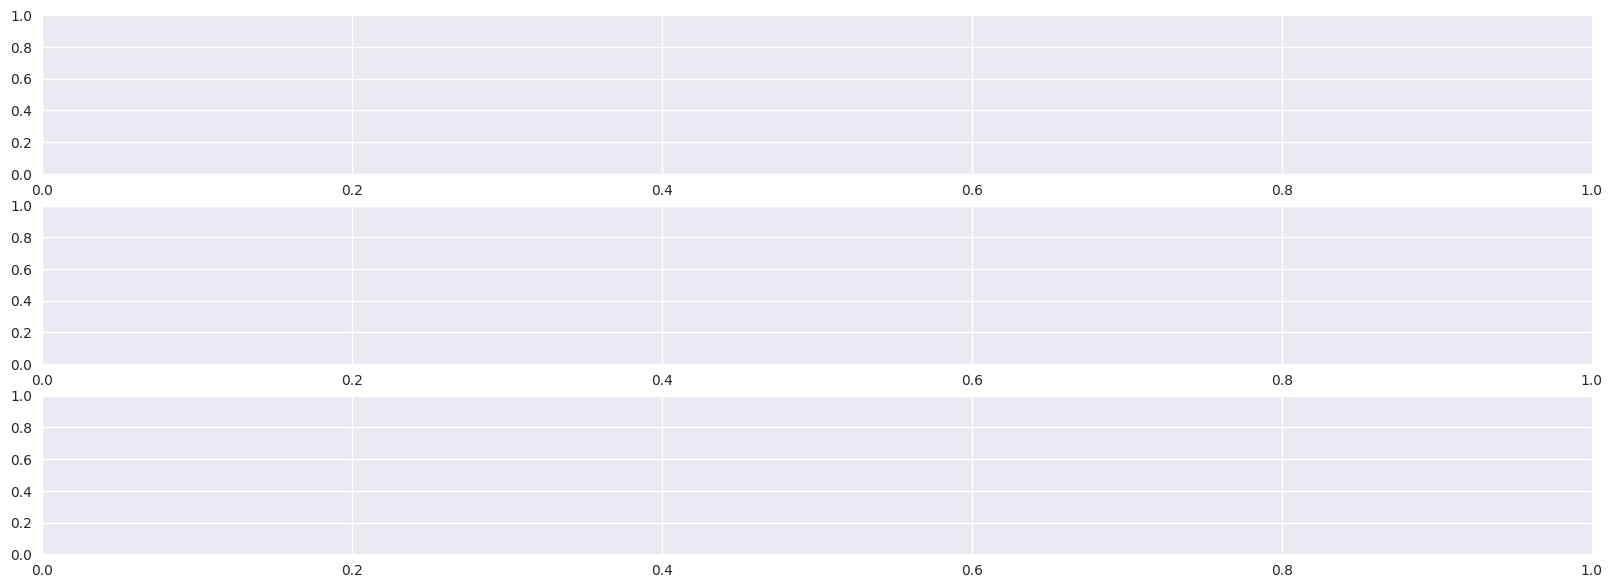

In [10]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(20,7))
ax1.plot(df_final.compound_total)
ax2.plot(df_final.index, df_final.kz_score)
ax3.plot(close_col.index, close_col.close)

In [ ]:
df = df_final.copy()
df.reset_index(drop=True, inplace=True)
df.head()

,st_stoch,st_ich,st_cut_ema5_sma10,st_macd,st_ich_close,st_dmi,st_cut_sma10_close,st_hisse,st_mfi,st_fishert,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,feature_label,kz_score,compound_total
0,1,1,1,0,1,0,0,0,2,2,...,1,0,1,1,1,1,0,1.0000,1.7033,0.1744
1,0,0,1,0,1,0,0,0,2,2,...,1,0,1,0,0,0,1,1.0000,1.2887,0.1280
2,0,1,0,1,1,1,0,0,2,2,...,1,1,0,1,1,1,1,1.0000,1.8482,0.1604
3,0,0,0,0,0,0,1,0,1,2,...,0,0,1,1,0,1,0,1.0000,0.6564,0.1499
4,0,1,1,1,1,0,0,0,2,2,...,1,0,0,1,1,0,0,1.0000,1.7057,0.1652


In [ ]:
y = df_final.log_return
X = df_final.drop(columns=['log_return'], axis=1)

In [ ]:
X

,st_stoch,st_ich,st_cut_ema5_sma10,st_macd,st_ich_close,st_dmi,st_cut_sma10_close,st_hisse,st_mfi,st_fishert,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,feature_label,kz_score,compound_total
2021-01-01,1,1,1,0,1,0,0,0,2,2,...,1,0,1,1,1,1,0,1.0000,1.7033,0.1744
2021-01-02,0,0,1,0,1,0,0,0,2,2,...,1,0,1,0,0,0,1,1.0000,1.2887,0.1280
2021-01-03,0,1,0,1,1,1,0,0,2,2,...,1,1,0,1,1,1,1,1.0000,1.8482,0.1604
2021-01-04,0,0,0,0,0,0,1,0,1,2,...,0,0,1,1,0,1,0,1.0000,0.6564,0.1499
2021-01-05,0,1,1,1,1,0,0,0,2,2,...,1,0,0,1,1,0,0,1.0000,1.7057,0.1652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,0,0,1,1,1,1,0,0,2,2,...,0,1,1,0,1,1,1,0.0000,1.9952,0.1090
2022-06-27,1,0,0,0,0,0,1,0,2,2,...,0,0,1,1,0,0,1,1.0000,0.6219,0.1052
2022-06-28,1,0,0,0,0,0,1,0,2,2,...,1,0,1,1,1,0,1,0.0000,0.7494,0.0993
2022-06-29,1,0,0,0,0,0,1,0,1,1,...,0,1,1,0,0,0,1,1.0000,0.6447,0.0898


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)
Training score:  0.9964045027492018
Mean cross-validation score: 0.45
K-fold CV average score: 0.45
MSE: 0.00
RMSE: 0.01


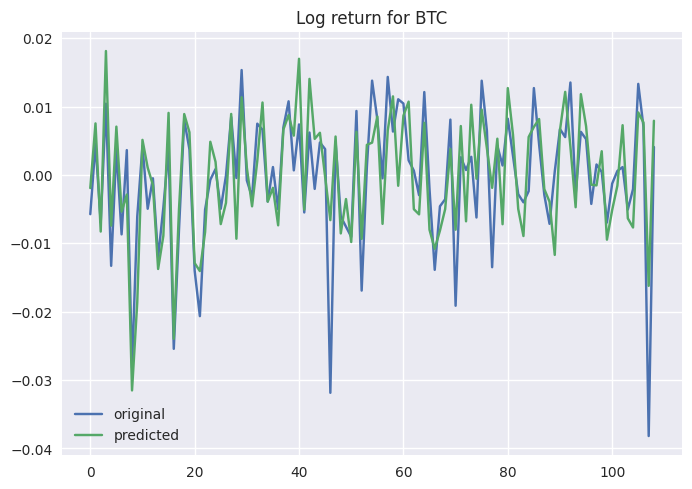

In [ ]:
from xgboost import XGBRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.20)
xgbr = XGBRegressor(tree_method='gpu_hist', n_estimators=150, verbosity=0) 
print(xgbr)

xgbr.fit(xtrain, ytrain)

score = xgbr.score(xtrain, ytrain)  
print("Training score: ", score)

scores = cross_val_score(xgbr, xtrain, ytrain,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=False)
kf_cv_scores = cross_val_score(xgbr, xtrain, ytrain, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

ypred_reg = xgbr.predict(xtest)
mse = mean_squared_error(ytest, ypred_reg)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

x_ax = range(len(ytest))
plt.plot(x_ax, ytest, label="original")
plt.plot(x_ax, ypred_reg, label="predicted")
plt.title("Log return for BTC")
plt.legend()
plt.show()

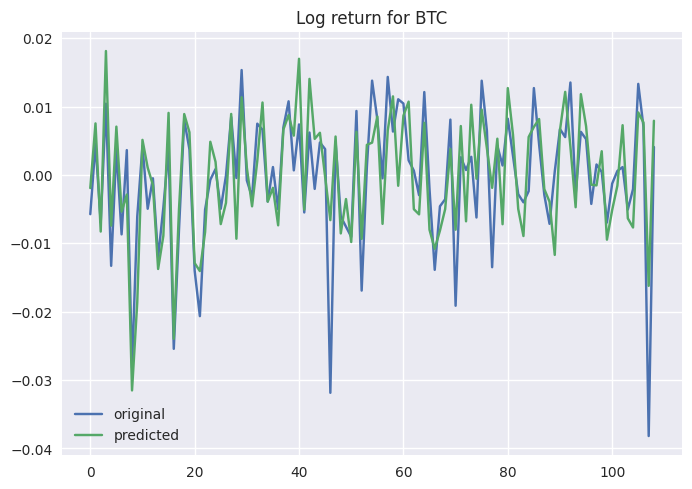

In [ ]:
x_ax = range(len(ytest))
plt.plot(x_ax, ytest, label="original")
plt.plot(x_ax, ypred_reg, label="predicted")
plt.title("Log return for BTC")
plt.legend()
plt.show()

In [ ]:
y = df_final.feature_label
X = df_final.drop(columns=['feature_label'], axis=1)

[0]	validation_0-logloss:0.68242	validation_1-logloss:0.69509
[1]	validation_0-logloss:0.67343	validation_1-logloss:0.69068
[2]	validation_0-logloss:0.66651	validation_1-logloss:0.68607
[3]	validation_0-logloss:0.66061	validation_1-logloss:0.68970
[4]	validation_0-logloss:0.65508	validation_1-logloss:0.68838
[5]	validation_0-logloss:0.65078	validation_1-logloss:0.68839
[6]	validation_0-logloss:0.64683	validation_1-logloss:0.69039
[7]	validation_0-logloss:0.64290	validation_1-logloss:0.69552
[8]	validation_0-logloss:0.63897	validation_1-logloss:0.68962
[9]	validation_0-logloss:0.63595	validation_1-logloss:0.68236
[10]	validation_0-logloss:0.63297	validation_1-logloss:0.68274
[11]	validation_0-logloss:0.62993	validation_1-logloss:0.68369
[12]	validation_0-logloss:0.62731	validation_1-logloss:0.68332
[13]	validation_0-logloss:0.62458	validation_1-logloss:0.68712
[14]	validation_0-logloss:0.62185	validation_1-logloss:0.69043
[15]	validation_0-logloss:0.61945	validation_1-logloss:0.69276
[1

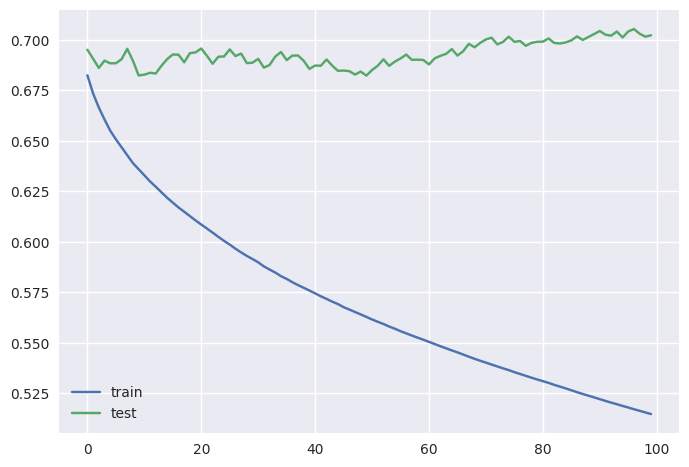

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)
model = XGBClassifier(n_estimators=100, tree_method='gpu_hist', eta=0.3, max_depth=1)
evalset = [(X_train, y_train), (X_test,y_test)]

model.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)
# evaluate performance
model.save_model('model_file_name.json')
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()
# plot learning curves

fig, ax = plt.subplots()
ax.plot(results['validation_0']['logloss'], label='train')
ax.plot(results['validation_1']['logloss'], label='test')
# show the legend
ax.legend()
# show the plot

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 2/5] END eta=0.3, max_depth=1, n_estimators=100;, score=-0.805 total time=   2.2s
[CV 1/5] END eta=0.3, max_depth=1, n_estimators=100;, score=-0.779 total time=   2.5s
[CV 3/5] END eta=0.3, max_depth=1, n_estimators=100;, score=-0.754 total time=   2.6s
[CV 3/5] END eta=0.3, max_depth=1, n_estimators=150;, score=-0.786 total time=   0.6s
[CV 2/5] END eta=0.3, max_depth=1, n_estimators=50;, score=-0.736 total time=   3.2s
[CV 3/5] END eta=0.3, max_depth=1, n_estimators=50;, score=-0.726 total time=   3.3s
[CV 4/5] END eta=0.3, max_depth=1, n_estimators=150;, score=-0.725 total time=   0.9s
[CV 5/5] END eta=0.3, max_depth=1, n_estimators=150;, score=-0.709 total time=   0.9s
[CV 1/5] END eta=0.3, max_depth=2, n_estimators=100;, score=-0.928 total time=   0.8s
[CV 1/5] END eta=0.3, max_depth=1, n_estimators=50;, score=nan total time=   3.5s
[CV 4/5] END eta=0.3, max_depth=1, n_estimators=100;, score=-0.702 total time=   3.8s


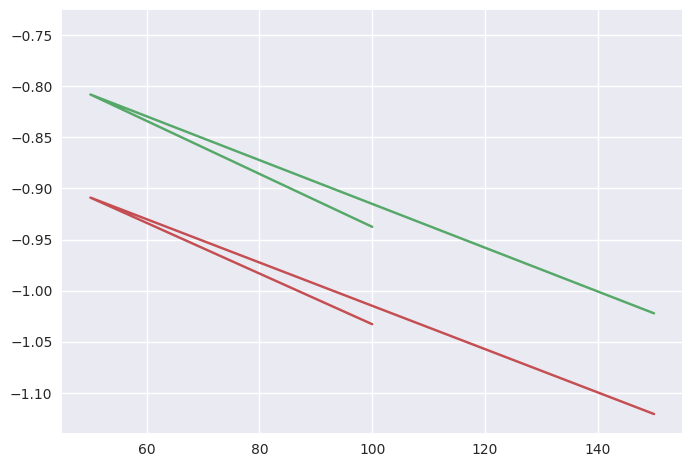

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold

model = XGBClassifier(tree_method='gpu_hist')
n_estimators = [100, 50, 150,] # , 200, 300, 500, 1000, 50, 100, 
max_depth = [1, 2, 3]  #, 6, 8, 12, 16
eta = [0.3]

param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, eta=eta)
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=tscv,
                verbose=3)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# plot results
import numpy
scores = numpy.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))

[0]	validation_0-logloss:0.59852	validation_1-logloss:0.70135
[1]	validation_0-logloss:0.53111	validation_1-logloss:0.71863
[2]	validation_0-logloss:0.47294	validation_1-logloss:0.72272
[3]	validation_0-logloss:0.43113	validation_1-logloss:0.73944
[4]	validation_0-logloss:0.39370	validation_1-logloss:0.75948
[5]	validation_0-logloss:0.35920	validation_1-logloss:0.75876
[6]	validation_0-logloss:0.31976	validation_1-logloss:0.76711
[7]	validation_0-logloss:0.29793	validation_1-logloss:0.77643
[8]	validation_0-logloss:0.28109	validation_1-logloss:0.77533
[9]	validation_0-logloss:0.25389	validation_1-logloss:0.79332
[10]	validation_0-logloss:0.22615	validation_1-logloss:0.78452
[11]	validation_0-logloss:0.21064	validation_1-logloss:0.80099
[12]	validation_0-logloss:0.19773	validation_1-logloss:0.81976
[13]	validation_0-logloss:0.18776	validation_1-logloss:0.81279
[14]	validation_0-logloss:0.18295	validation_1-logloss:0.82884
[15]	validation_0-logloss:0.16784	validation_1-logloss:0.82302
[1

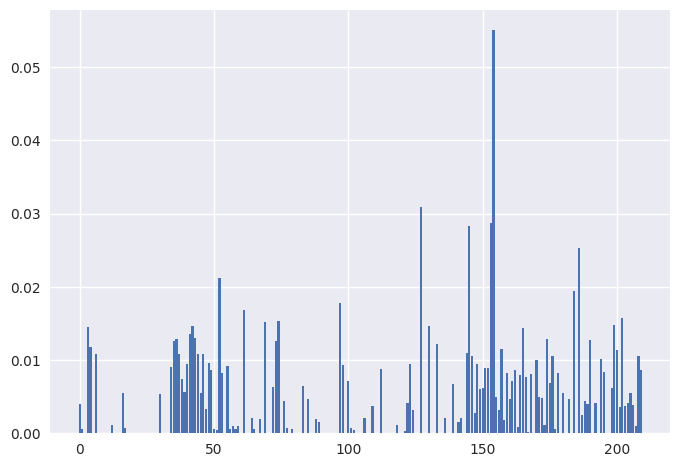

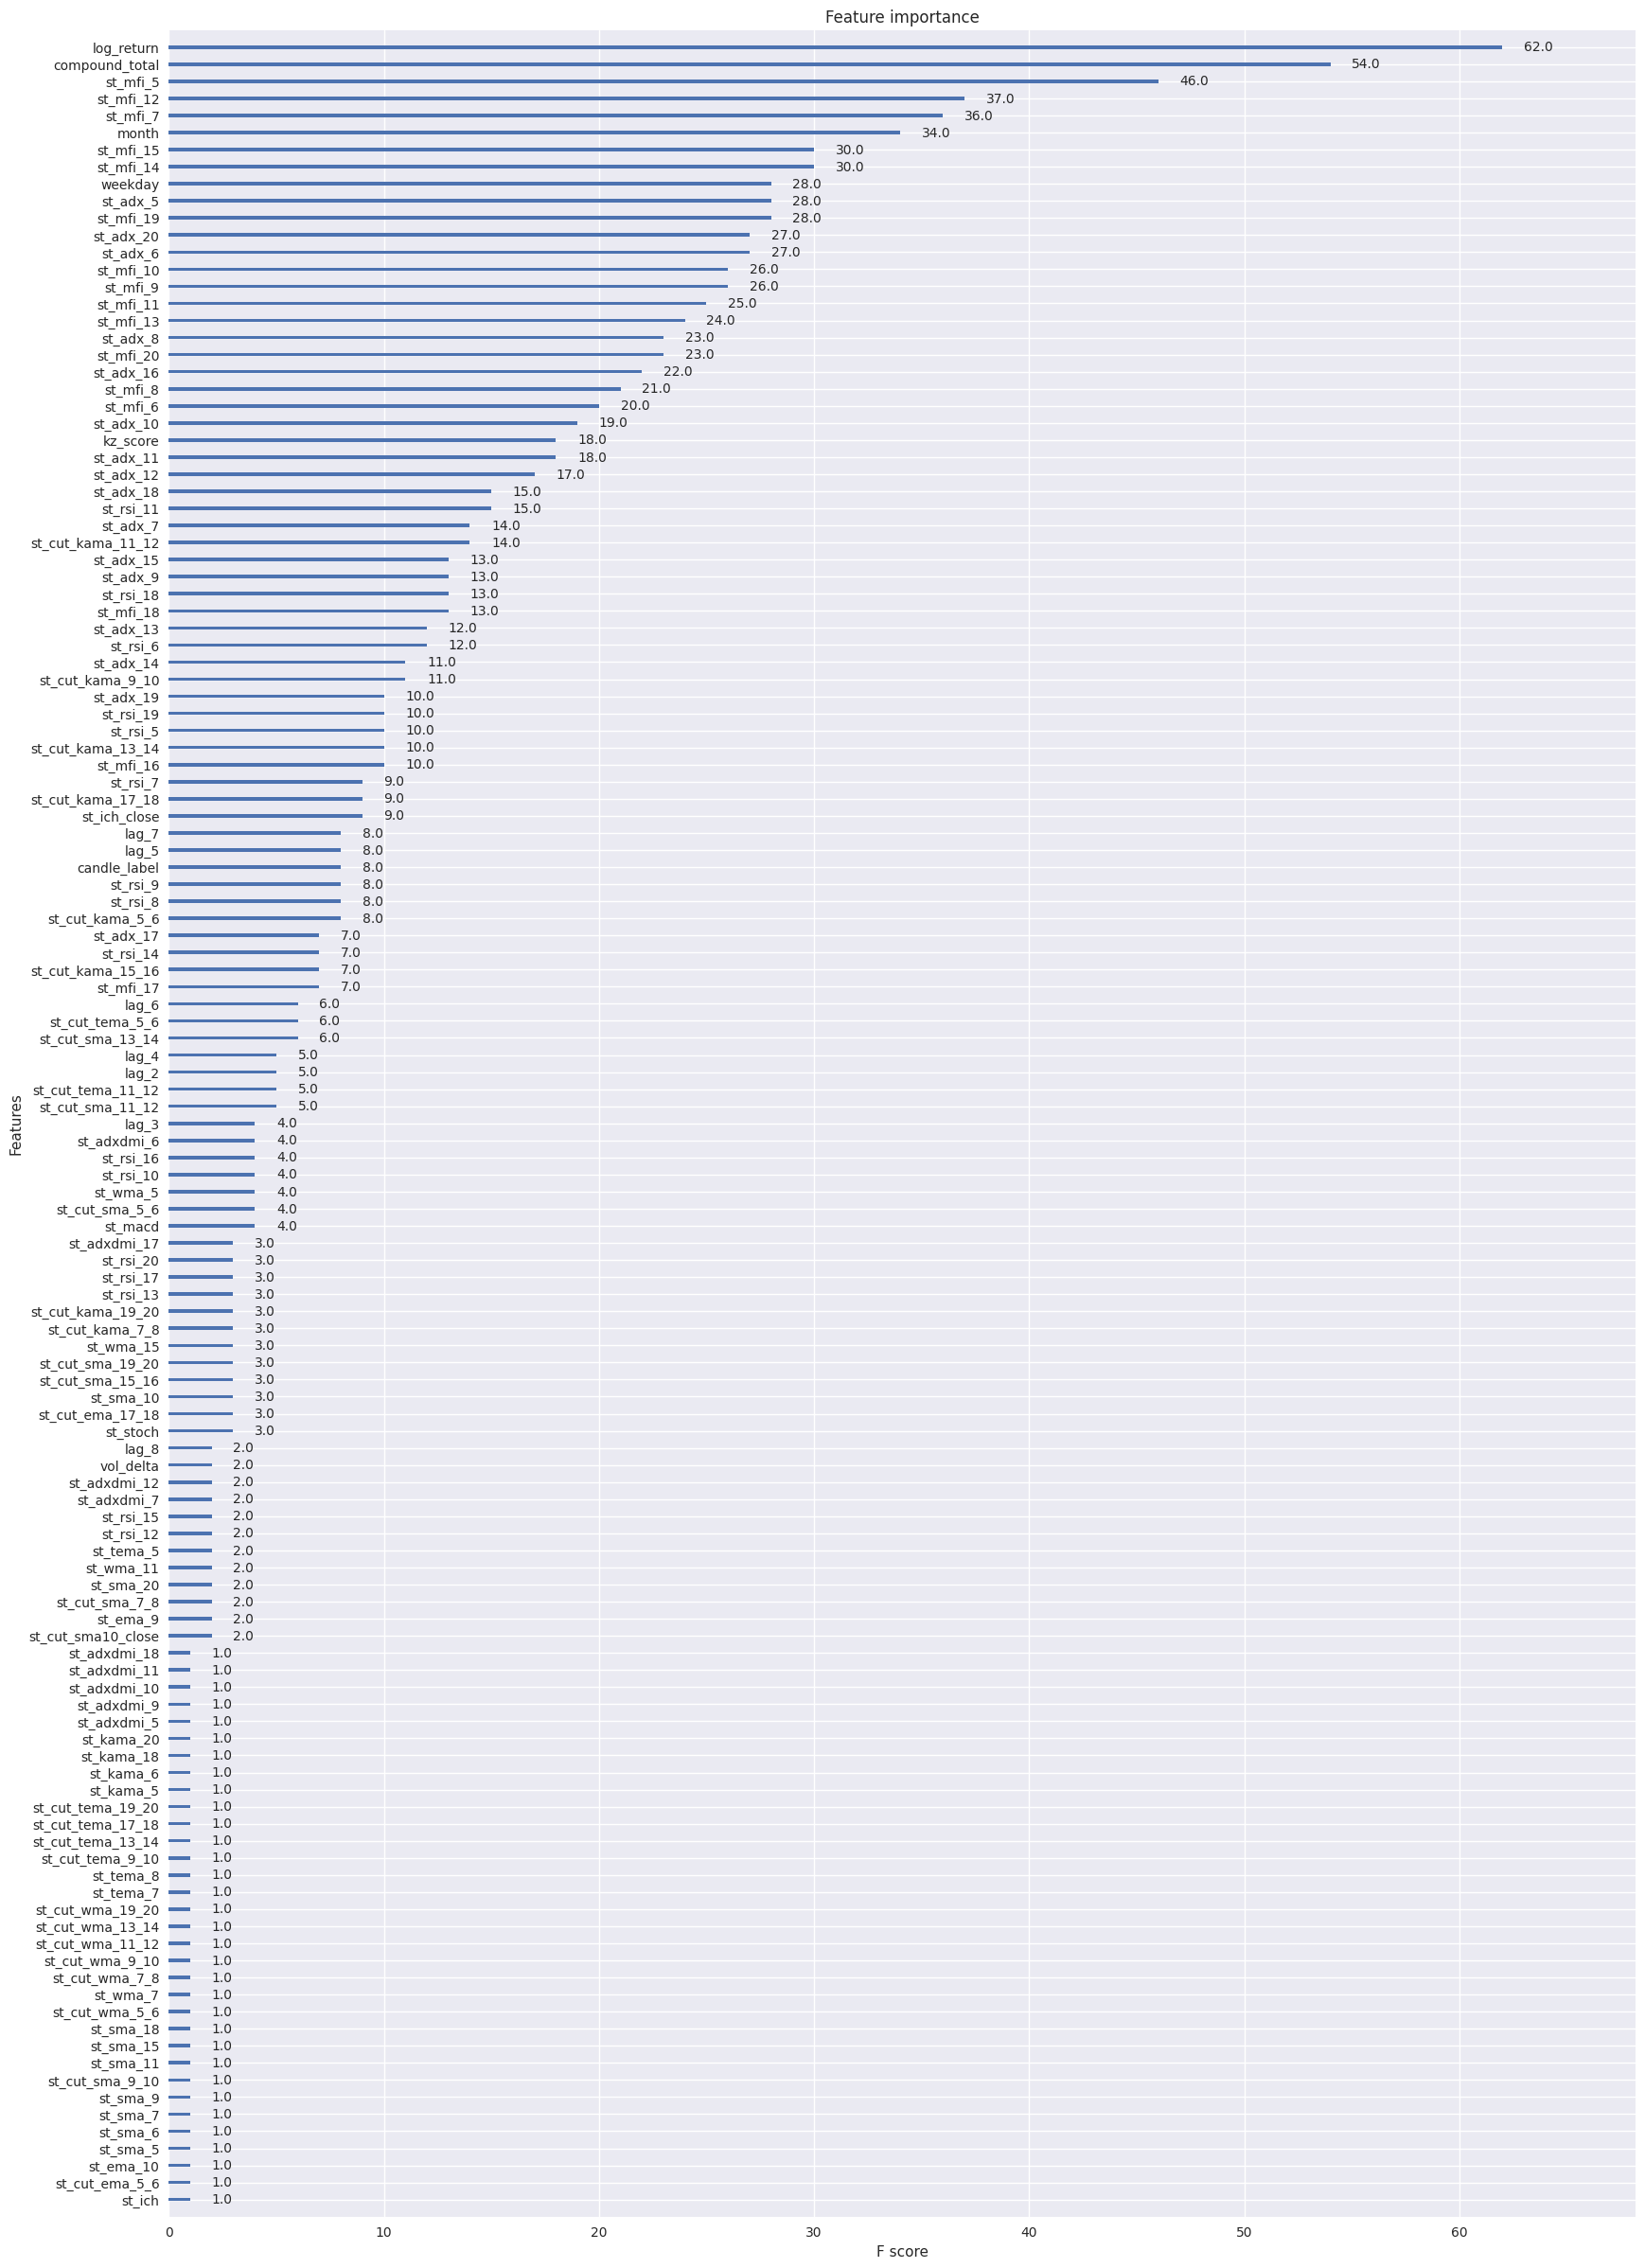

In [ ]:
# After model.fit(x,y)
model.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)
print(model.feature_importances_)
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
#pyplot.show()

from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(20,30))
plot_importance(model, ax=ax)
plt.show()